In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.stats
from matplotlib import pyplot
import random

In [2]:
epochs = 1000
min_epochs = 200

dataset_name = 'quadratic'

synthetic_dataset_kwargs = {
    'xmin' : -10,
    'xmax' : 10,
    'power' : 2,
    'coefficients' : [-2, 0, 2],
    'noise_scale' : 1
}

upper_y_lim = 250
lower_y_lim = -250
num_points = 501

In [3]:
rng = random.Random(0)
np.random.seed(rng.randint(0, pow(2,32))-1)
random.seed(rng.randint(0, pow(2,32))-1)

In [4]:
def generate_sample(xmin, xmax, power, coefficients, sample_size, noise_scale):
    x = np.random.uniform(xmin, xmax, size=(sample_size,))
    y = np.power(x, power)
    y = y * np.random.choice(coefficients, size=(sample_size,))
    y = y + (noise_scale * np.abs(x) * np.random.normal(size=(sample_size,)))
    return x, y

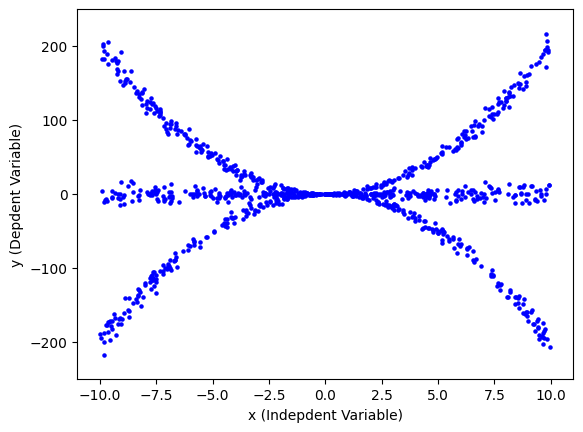

In [5]:
x,y = generate_sample(sample_size=100000, **synthetic_dataset_kwargs)
linear_dataset_sample = pd.DataFrame([x, y]).T
linear_dataset_sample.columns = ["x (Indepdent Variable)", "y (Depdent Variable)"]
ax = linear_dataset_sample.sample(1000).plot.scatter(x=0, y=1, c='blue', s=5, xlim=(-11, 11), ylim=(-250, 250))
ax.figure.savefig(f"{dataset_name}_dataset.png")

In [6]:
def training_dataset_generator_nll(generator_kwargs, batch_size = 32, sample_size = 1000000):
    x, y = generate_sample(sample_size=sample_size, **generator_kwargs)
    while(True):
        selected_indexes = np.random.choice(range(sample_size), size=batch_size)
        threshold = np.random.choice(y, size=batch_size)
        batch_x = x[selected_indexes].reshape(-1,1)
        batch_y = y[selected_indexes].reshape(-1,1)
        yield ([batch_x, batch_y], np.zeros(shape=(batch_size,)))

def training_dataset_generator_implicit(generator_kwargs, batch_size = 32, sample_size = 1000000):
    x, y = generate_sample(sample_size=sample_size, **generator_kwargs)
    while(True):
        selected_indexes = np.random.choice(range(sample_size), size=batch_size)
        threshold = np.random.choice(y, size=batch_size)*np.exp(np.random.normal(size=(batch_size))*0.3)
        batch_x = np.concatenate([x[selected_indexes].reshape(-1,1), threshold.reshape(-1,1)], axis=-1)
        batch_y = (y[selected_indexes] < threshold).reshape(-1,1).astype(int)
        yield (batch_x, batch_y)

In [7]:
def build_nll_model(width, depth, activation):
    model_input = tf.keras.Input(shape=(1,))
    dependent_variable = tf.keras.Input(shape=(1,))


    layers = [tf.keras.layers.Dense(units=width, activation=activation) for _ in range(depth)]
    layers = [tf.keras.layers.InputLayer(input_shape=(1,))] + layers

    ann = tf.keras.Sequential(layers)
    ann_output = ann(model_input)

    mean = tf.keras.layers.Dense(1)(ann_output)
    log_std = tf.keras.layers.Dense(1)(ann_output)
    std = tf.math.exp(log_std)

    gaussian_nll = log_std + (0.5*tf.math.pow((mean - dependent_variable)/(std+1e-5), 2))

    model = tf.keras.Model(inputs=[model_input, dependent_variable], outputs= [mean, std])
    model.add_loss(gaussian_nll)

    return model

def build_implicit_model(width, depth, activation):
    layers = [tf.keras.layers.Dense(units=width, activation=activation) for _ in range(depth-1)]
    layers = layers + [tf.keras.layers.Dense(units=width, activation='tanh') for _ in range(1)]
    layers = [tf.keras.layers.InputLayer(input_shape=(2,))] + layers + [tf.keras.layers.Dense(1, activation='sigmoid')]
    return tf.keras.Sequential(layers)

In [8]:
tf.keras.backend.clear_session()

tf.keras.utils.set_random_seed(rng.randint(0, pow(2,32))-1)
tf.random.set_seed(rng.randint(0, pow(2,32))-1)

train_batch_generator = training_dataset_generator_nll(synthetic_dataset_kwargs)
validation_batch_generator = training_dataset_generator_nll(synthetic_dataset_kwargs, batch_size=1024)

nll_model_filepath = f"nll_model_{dataset_name}_dataset.h5"

nll_model = build_nll_model(512, 16, 'relu')
nll_model.compile(tf.keras.optimizers.Adam(clipvalue=1))
nll_model.fit(
    x=train_batch_generator,
    epochs=epochs,
    steps_per_epoch=100,
    validation_data=(validation_batch_generator,None),
    validation_steps=1,
    verbose=0,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=20, restore_best_weights=True, start_from_epoch=min_epochs),
        tf.keras.callbacks.ModelCheckpoint(nll_model_filepath, save_best_only=True, verbose=1)
    ]
)


Epoch 1: val_loss improved from inf to 26.22588, saving model to nll_model_quadratic_dataset.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 26.22588

Epoch 3: val_loss improved from 26.22588 to 5.32215, saving model to nll_model_quadratic_dataset.h5

Epoch 4: val_loss improved from 5.32215 to 5.05215, saving model to nll_model_quadratic_dataset.h5

Epoch 5: val_loss did not improve from 5.05215

Epoch 6: val_loss did not improve from 5.05215

Epoch 7: val_loss improved from 5.05215 to 4.77083, saving model to nll_model_quadratic_dataset.h5

Epoch 8: val_loss did not improve from 4.77083

Epoch 9: val_loss did not improve from 4.77083

Epoch 10: val_loss improved from 4.77083 to 4.16740, saving model to nll_model_quadratic_dataset.h5

Epoch 11: val_loss did not improve from 4.16740

Epoch 12: val_loss did not improve from 4.16740

Epoch 13: val_loss did not improve from 4.16740

Epoch 14: val_loss did not improve from 4.16740

Epoch 15: val_loss did not improve from 4.16740

Epoch 16: val_loss did not improve from 4.16740

Epoch 17: val_loss did not improve from 4.16740

Epoch 18: val

In [9]:
tf.keras.backend.clear_session()

tf.keras.utils.set_random_seed(rng.randint(0, pow(2,32))-1)
tf.random.set_seed(rng.randint(0, pow(2,32))-1)

train_batch_generator = training_dataset_generator_implicit(synthetic_dataset_kwargs)
validation_batch_generator = training_dataset_generator_implicit(synthetic_dataset_kwargs, batch_size=1024)

implicit_model_filepath = f"implicit_model_{dataset_name}_dataset.h5"

implicit_model = build_implicit_model(512, 16, 'relu')
implicit_model.compile(tf.keras.optimizers.Adam(clipvalue=1), loss='binary_crossentropy')
implicit_model.fit(
    x=train_batch_generator,
    epochs=epochs,
    steps_per_epoch=100,
    validation_data=(validation_batch_generator,None),
    validation_steps=1,
    verbose=0,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=20, restore_best_weights=True, start_from_epoch=min_epochs),
        tf.keras.callbacks.ModelCheckpoint(implicit_model_filepath, save_best_only=True, verbose=1)
    ]
)


Epoch 1: val_loss improved from inf to 0.52212, saving model to implicit_model_quadratic_dataset.h5

Epoch 2: val_loss did not improve from 0.52212

Epoch 3: val_loss improved from 0.52212 to 0.48708, saving model to implicit_model_quadratic_dataset.h5

Epoch 4: val_loss did not improve from 0.48708

Epoch 5: val_loss did not improve from 0.48708

Epoch 6: val_loss did not improve from 0.48708

Epoch 7: val_loss did not improve from 0.48708

Epoch 8: val_loss did not improve from 0.48708

Epoch 9: val_loss did not improve from 0.48708

Epoch 10: val_loss did not improve from 0.48708

Epoch 11: val_loss did not improve from 0.48708

Epoch 12: val_loss improved from 0.48708 to 0.48231, saving model to implicit_model_quadratic_dataset.h5

Epoch 13: val_loss improved from 0.48231 to 0.47391, saving model to implicit_model_quadratic_dataset.h5

Epoch 14: val_loss did not improve from 0.47391

Epoch 15: val_loss did not improve from 0.47391

Epoch 16: val_loss did not improve from 0.47391



In [10]:
def generate_pdf_implicit_model(implicit_model, y_min, y_max, x_val, n_steps, smoothing_filter, n_filter_applications):
    y_range = np.linspace(y_min, y_max, n_steps)
    y = tf.constant(y_range.reshape(-1,1), dtype=tf.float32)
    x = tf.constant([[x_val]] * num_points, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(y)  # Start recording the history of operations applied to `a`
        implicit_model_input = tf.concat([x, y], axis=1)
        pdf = tape.gradient(implicit_model(implicit_model_input), y)
    
    pdf_hat = pdf.numpy().flatten()
    pdf_hat = np.where(pdf_hat>=0, pdf_hat, 0)
    for _ in range(n_filter_applications):
        pdf_hat = np.convolve(pdf_hat, smoothing_filter, 'same')
    
    return pdf_hat

def get_implicit_model_likelihood(implicit_model, y_min, y_max, x_val, y_val, n_steps, smoothing_filter, n_filter_applications):
    pdf_hat = generate_pdf_implicit_model(implicit_model, y_min, y_max, x_val, n_steps, smoothing_filter, n_filter_applications)
    y_range = np.linspace(y_min, y_max, n_steps)
    return max(pdf_hat[np.abs(y_val-y_range).argmin()], 1e-5)

def get_actual_likelihood(x, y, synthetic_dataset_kwargs):
    likelihoods = []
    for coefficient in synthetic_dataset_kwargs['coefficients']:
        likelihoods.append(
            scipy.stats.norm(
                coefficient*np.power(x, synthetic_dataset_kwargs['power']),
                np.abs(x)*synthetic_dataset_kwargs['noise_scale']
            ).pdf(y)
        )
    return np.array(likelihoods).mean()

In [11]:
smoothing_filter = np.concatenate([np.linspace(0,1,11), np.linspace(1,0,11)[1:]], axis=0)
smoothing_filter = smoothing_filter/smoothing_filter.sum()
smoothing_filter

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.  ])

In [12]:
tf.keras.backend.clear_session()
nll_model = tf.keras.saving.load_model(nll_model_filepath)
implicit_model = tf.keras.saving.load_model(implicit_model_filepath)

X = -10


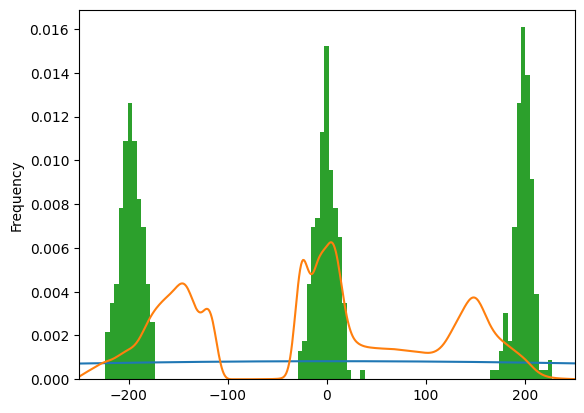

X = -9


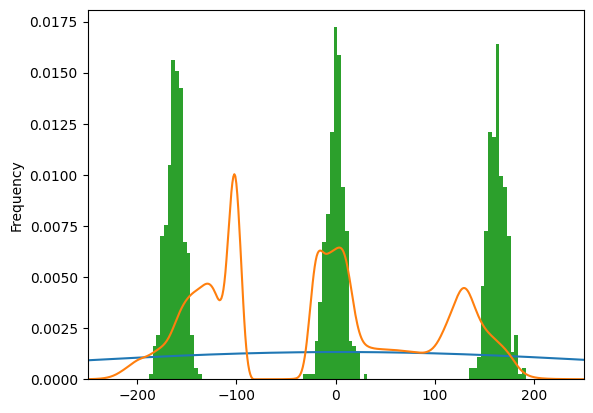

X = -8


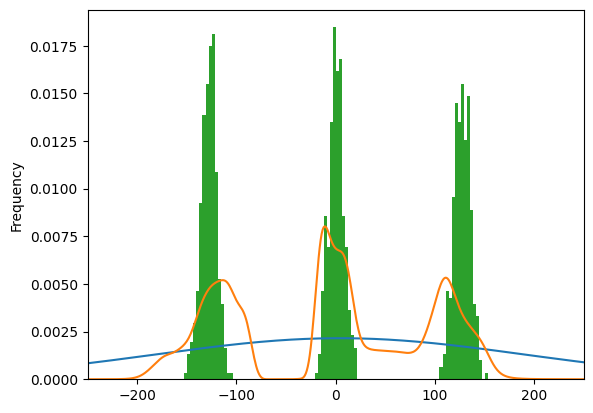

X = -7


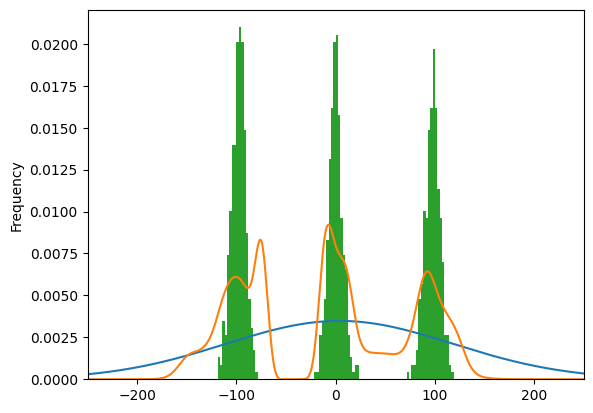

X = -6


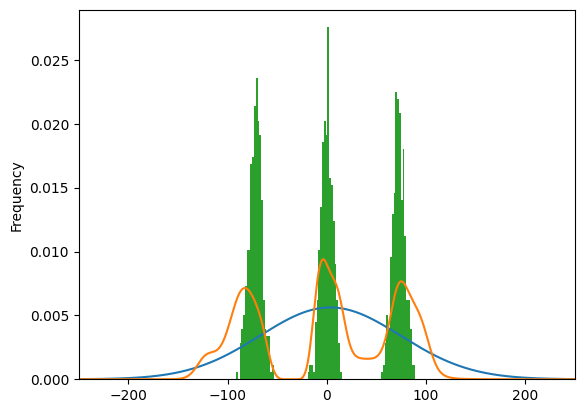

X = -5


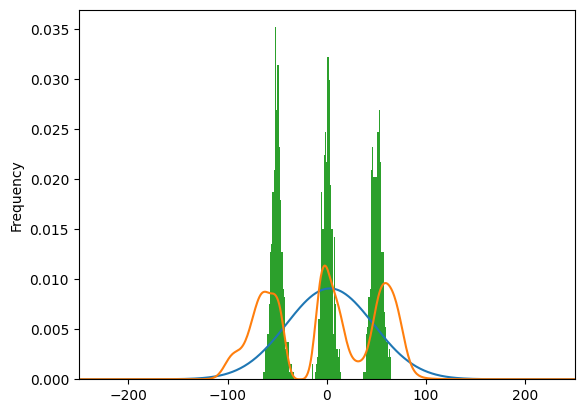

X = -4


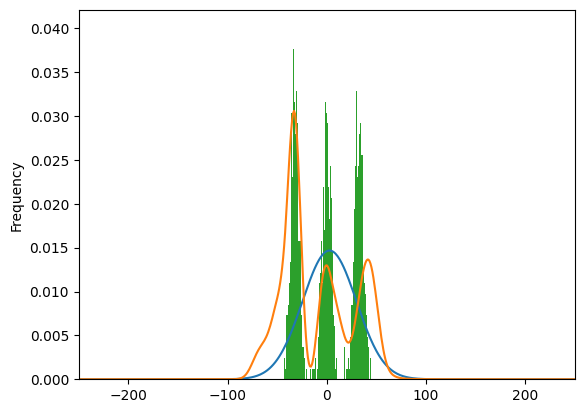

X = -3


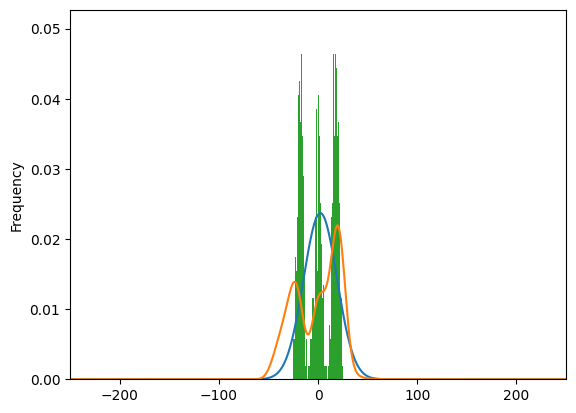

X = -2


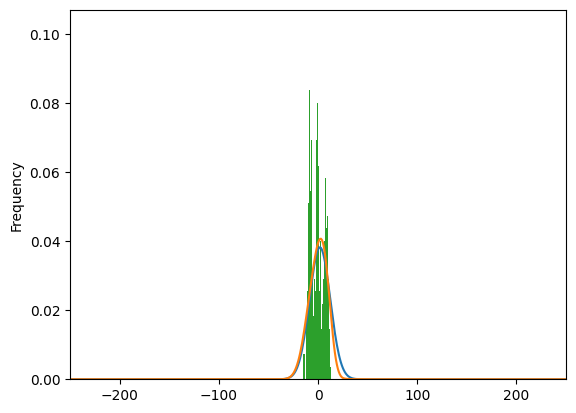

X = -1


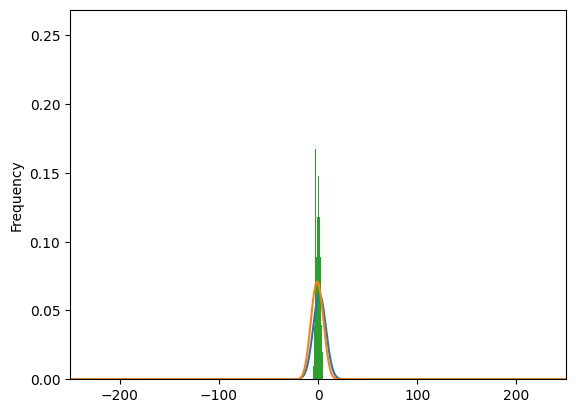

X = 0


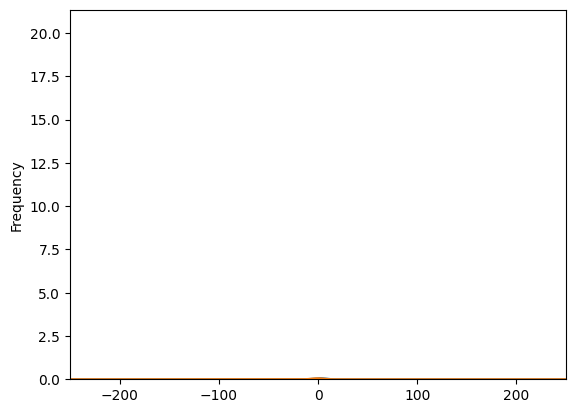

X = 1


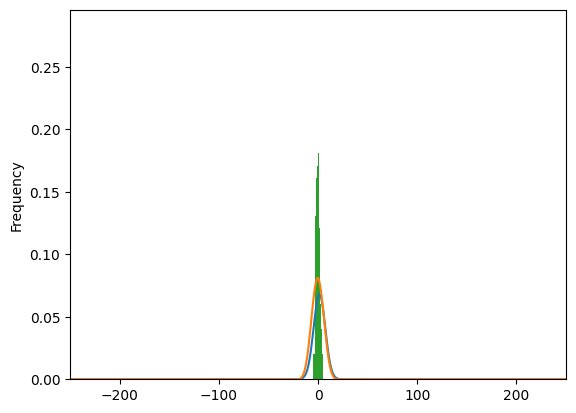

X = 2


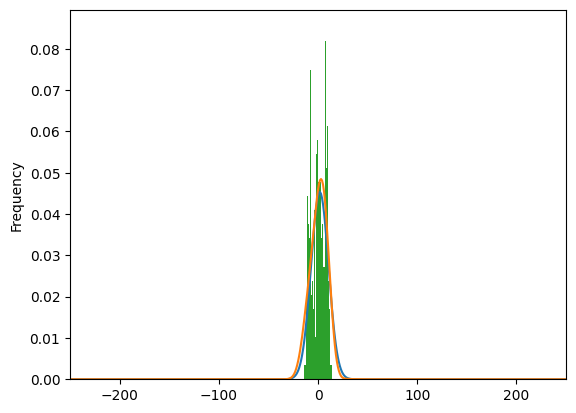

X = 3


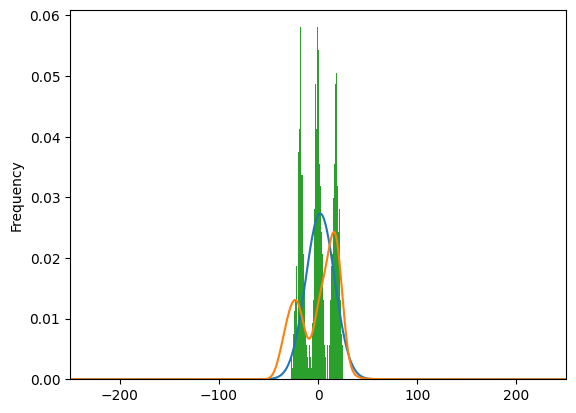

X = 4


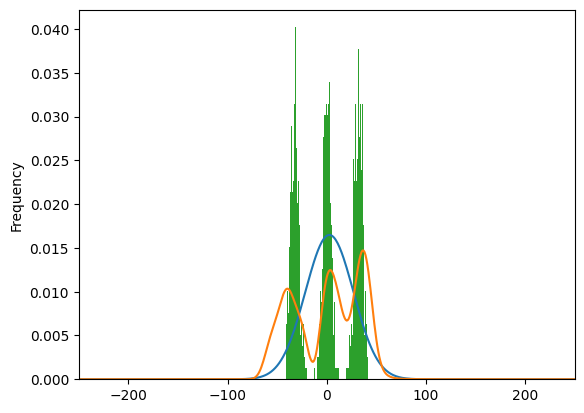

X = 5


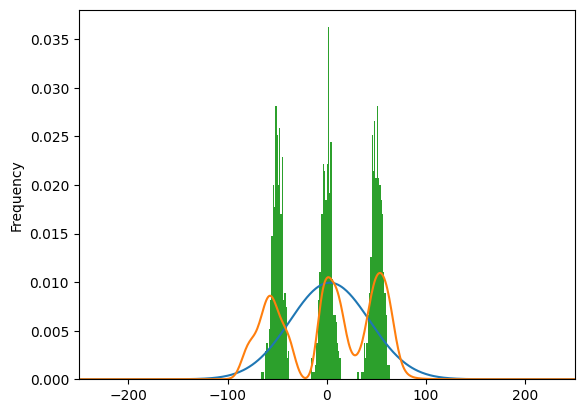

X = 6


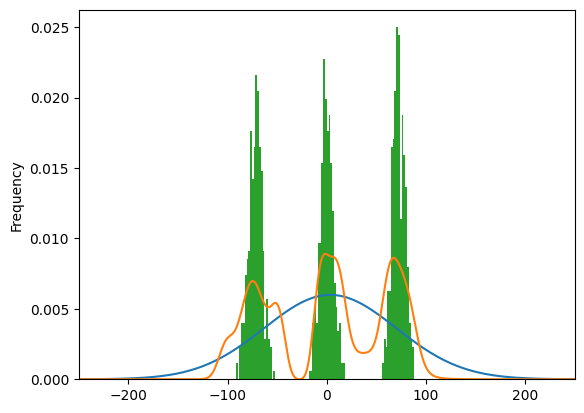

X = 7


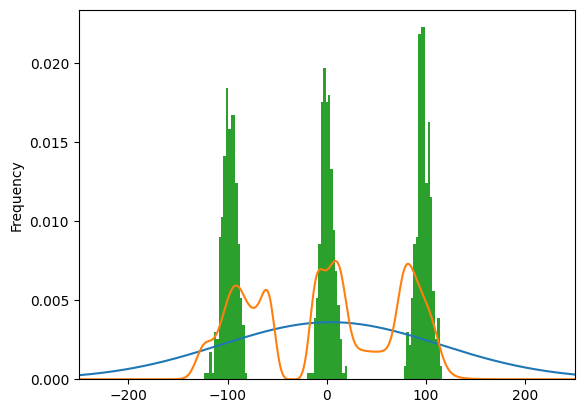

X = 8


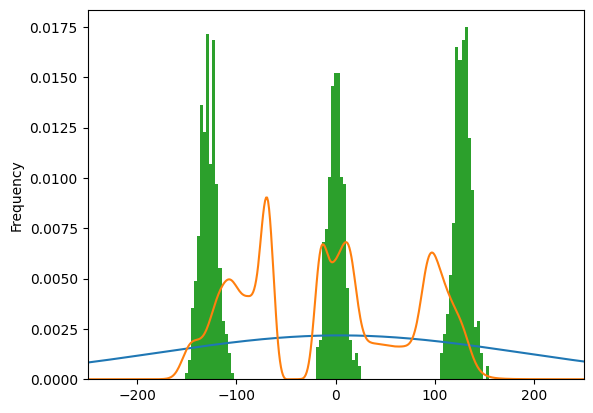

X = 9


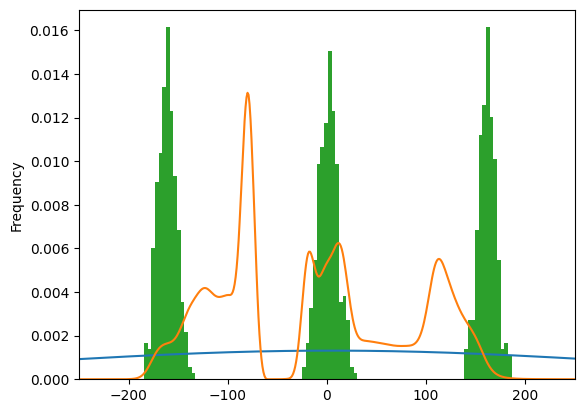

X = 10


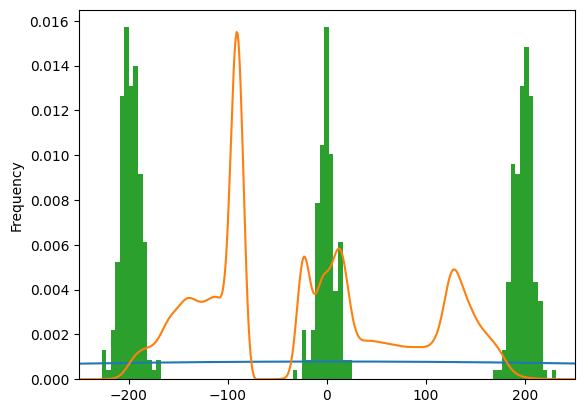

In [13]:
for independent_variable in range(-10,11):
    print(f"X = {independent_variable}")
    idx = np.linspace(lower_y_lim,upper_y_lim,num_points)
    op = nll_model.predict([np.array([[independent_variable]]), np.array([[0]])], verbose=0)
    pdf_hat_nll = scipy.stats.norm(op[0][0,0], op[1][0,0]).pdf
    pd.Series(pdf_hat_nll(idx), index=idx).plot()
    pdf_hat_implicit = generate_pdf_implicit_model(implicit_model, lower_y_lim,upper_y_lim, independent_variable, num_points, smoothing_filter, 2)
    pd.Series(pdf_hat_implicit, index=idx).plot()
    pd.Series(y[(x>(independent_variable-0.1)) & (x<(independent_variable+0.1))]).plot.hist(bins=100, xlim=(lower_y_lim,upper_y_lim), density=True, cumulative=False)
    pyplot.show()

In [14]:
test_data_size = 1000
x_test, y_test = generate_sample(sample_size=test_data_size, **synthetic_dataset_kwargs)

In [15]:
actual_likelihoods = []
for x_val, y_val in zip(x_test, y_test):
    actual_likelihoods.append(get_actual_likelihood(x_val, y_val, synthetic_dataset_kwargs))

In [16]:
nll_op = nll_model.predict([x_test, np.zeros(shape=(test_data_size,1))], 1024, verbose=0)
nll_mean = nll_op[0].flatten()
nll_std = nll_op[1].flatten()
nll_model_likelihoods = (1/np.sqrt(2*np.pi))*(1/nll_std)*np.exp(-0.5*np.power((y_test-nll_mean)/nll_std, 2))

In [17]:
implicit_model_likelihoods = []
for x_val, y_val in zip(x_test, y_test):
    implicit_model_likelihoods.append(
        get_implicit_model_likelihood(implicit_model, lower_y_lim,upper_y_lim, x_val, y_val, num_points, smoothing_filter, 2)
    )

In [18]:
print(f"     Likelihood from the real distribution : {np.log(np.array(actual_likelihoods)).mean().round(3)}")
print(f"     NLL Model Log Likelihood on test data : {np.log(nll_model_likelihoods).mean().round(3)}")
print(f"Implicit Model Log Likelihood on test data : {np.log(np.array(implicit_model_likelihoods)).mean().round(3)}")

     Likelihood from the real distribution : -3.646
     NLL Model Log Likelihood on test data : -4.902
Implicit Model Log Likelihood on test data : -4.562
